# Optimal Control Problem

The problem then reduces to finding a pair $(\psi, u)$ that minimizes 
$$
J(\psi, u) = \frac{1}{2} \|\psi(\cdot,T) - \psi^\dagger \|_{L^2(R^d)}^2 + \frac{\nu}{2} \int_0^T \|u(t) \|_2^2 \, dt,
$$
where $\psi^\dagger = U^{-1} \rho^\dagger$, subject to the controlled equation
$$
\partial_t \psi = - \mathcal{H} \psi + \sum_{i=1}^m u_i(t) \, \mathcal{N}_i \psi.
$$

In [1]:
import numpy as np
import sympy as sp

from schorodinger_operator import WolframNDEigensystemApproximator
from schorodinger_operator import SchrodingerControlSolver

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Example 1: $V(x) = x^2/2$

We start with the simple example $V(x) = x^2 / 2$, which does not show good properties for our puorposes, but might be interesting. 

In [6]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="0.25*x^2-0.5",
    L=10.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.5}
)

def potential(x): return 0.5 * x**2

def rho_0(x):
    return np.exp(-(x + 2.0)**2 / 2) / np.sqrt(2*np.pi)

def rho_dag(x):
    return np.exp(-x**2 / 2 ) / np.sqrt(2*np.pi)

def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=rho_dag,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: x,
    correct_lambda0=True
)

T = 10.0
result_control = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                              learning_rate_kwargs={'gamma': 1})

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

Iteration 1: ||grad|| = 5.153e-04, gamma = 1
Iteration 2: ||grad|| = 2.577e-04, gamma = 1
Iteration 3: ||grad|| = 1.289e-04, gamma = 1
Iteration 4: ||grad|| = 6.448e-05, gamma = 1
Iteration 5: ||grad|| = 3.230e-05, gamma = 1
Iteration 6: ||grad|| = 1.628e-05, gamma = 1
Iteration 7: ||grad|| = 8.391e-06, gamma = 1
Iteration 8: ||grad|| = 4.663e-06, gamma = 1
Iteration 9: ||grad|| = 3.094e-06, gamma = 1
Iteration 10: ||grad|| = 2.556e-06, gamma = 1
Iteration 11: ||grad|| = 2.402e-06, gamma = 1
Iteration 12: ||grad|| = 2.362e-06, gamma = 1
Iteration 13: ||grad|| = 2.352e-06, gamma = 1
Iteration 14: ||grad|| = 2.350e-06, gamma = 1
Iteration 15: ||grad|| = 2.349e-06, gamma = 1
Iteration 16: ||grad|| = 2.349e-06, gamma = 1
Iteration 17: ||grad|| = 2.349e-06, gamma = 1
Iteration 18: ||grad|| = 2.349e-06, gamma = 1
Iteration 19: ||grad|| = 2.349e-06, gamma = 1
Iteration 20: ||grad|| = 2.349e-06, gamma = 1
Iteration 21: ||grad|| = 2.349e-06, gamma = 1
Iteration 22: ||grad|| = 2.349e-06, gamma =

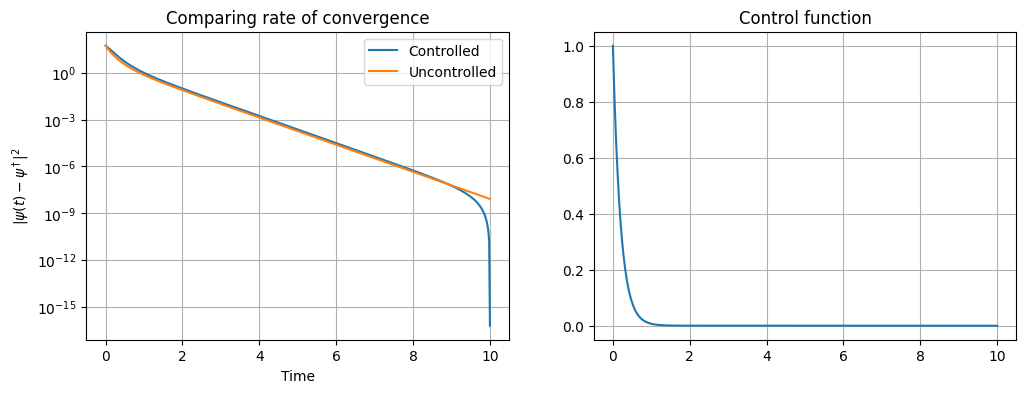

In [7]:
time_grid = result['time']
u_vals = result_control['u_vals'][:, 0]

diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_grid, diff_control, label='Controlled')
ax[0].plot(time_grid, diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(time_grid, u_vals)
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

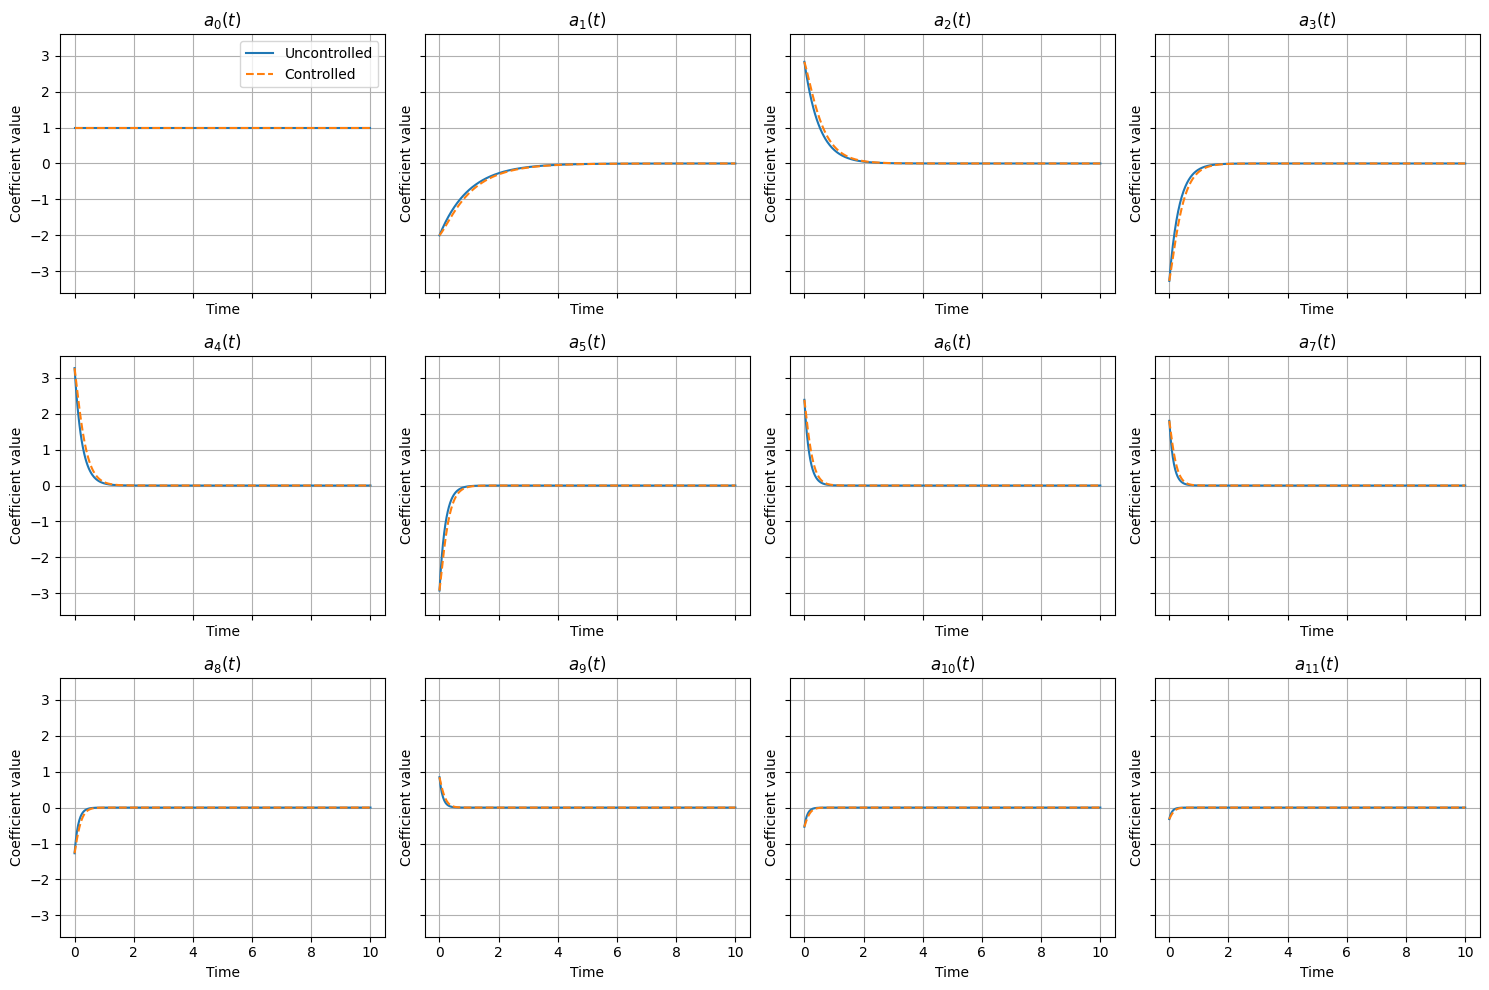

In [8]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(time_grid, result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(time_grid, result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 2: $V(x) = (x^2 - 1.5)^2$

In this example, I chose $\alpha$ "smartly".

In [9]:
x = sp.symbols('x')
potential = (x**2 - 1.5)**2

potential_prime = sp.diff(potential, x)
potential_double_prime = sp.diff(potential_prime, x)

expression = 0.25 * potential_prime**2 - 0.5 * potential_double_prime
print(expression.simplify())

4.0*x**6 - 12.0*x**4 + 3.0*x**2 + 3.0


In [13]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, max_iter=100, tol=1e-8, time_eval=np.linspace(0, T, 501), verbose=True,
                              learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.8, 'beta': 0.9},
                              #learning_rate_kwargs={'gamma': 1}
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

Iteration 1: ||grad|| = 7.054e-02, gamma = 100
Iteration 2: ||grad|| = 6.461e-02, gamma = 100
Iteration 3: ||grad|| = 5.884e-02, gamma = 100
Iteration 4: ||grad|| = 5.434e-02, gamma = 100
Iteration 5: ||grad|| = 5.007e-02, gamma = 100
Iteration 6: ||grad|| = 4.659e-02, gamma = 100
Iteration 7: ||grad|| = 4.340e-02, gamma = 100
Iteration 8: ||grad|| = 4.062e-02, gamma = 100
Iteration 9: ||grad|| = 3.821e-02, gamma = 100
Iteration 10: ||grad|| = 3.589e-02, gamma = 100
Iteration 11: ||grad|| = 3.402e-02, gamma = 100
Iteration 12: ||grad|| = 3.202e-02, gamma = 100
Iteration 13: ||grad|| = 3.053e-02, gamma = 100
Iteration 14: ||grad|| = 2.876e-02, gamma = 100
Iteration 15: ||grad|| = 2.753e-02, gamma = 100
Iteration 16: ||grad|| = 2.592e-02, gamma = 100
Iteration 17: ||grad|| = 2.490e-02, gamma = 100
Iteration 18: ||grad|| = 2.342e-02, gamma = 100
Iteration 19: ||grad|| = 2.254e-02, gamma = 100
Iteration 20: ||grad|| = 2.120e-02, gamma = 100
Iteration 21: ||grad|| = 2.043e-02, gamma = 100
I

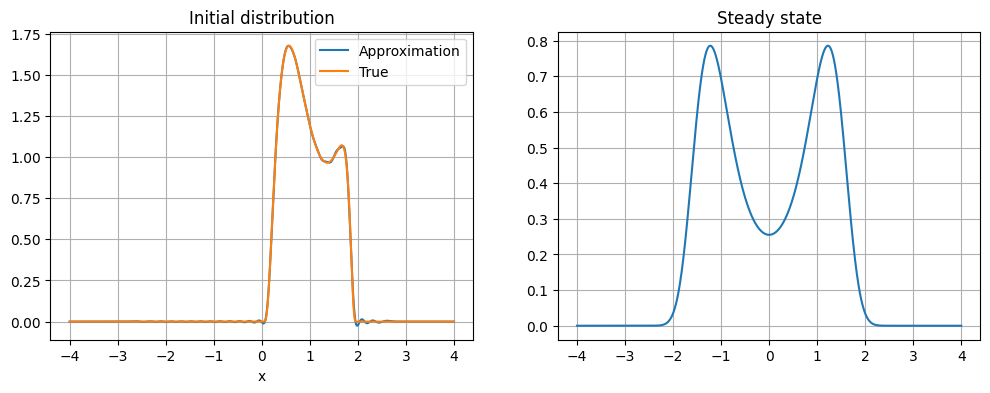

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(solver.x, result['psi'][0,:], label='Approximation')
ax[0].plot(solver.x, rho_0(solver.x) / np.sqrt(solver.rho_infty(solver.x)), label='True')

ax[0].set_xlabel('x')
ax[0].set_title('Initial distribution')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(solver.x, np.sqrt(solver.rho_infty(solver.x)))
ax[1].grid(True)
ax[1].set_title("Steady state")

plt.show()

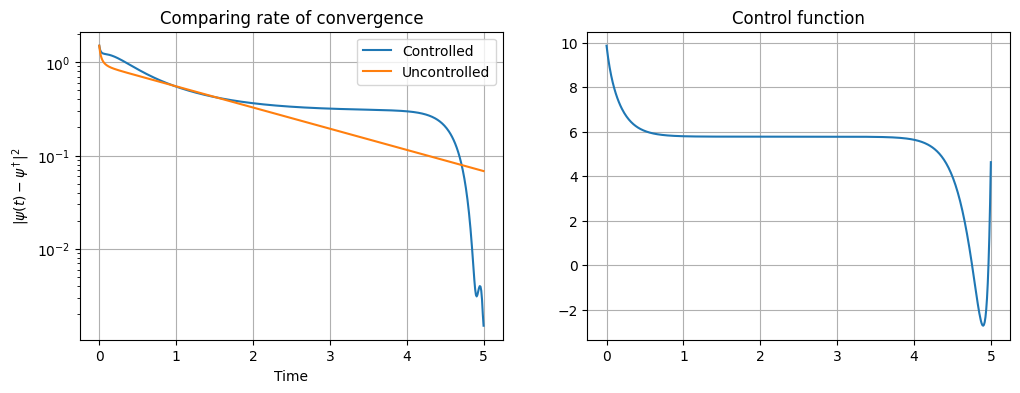

In [15]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

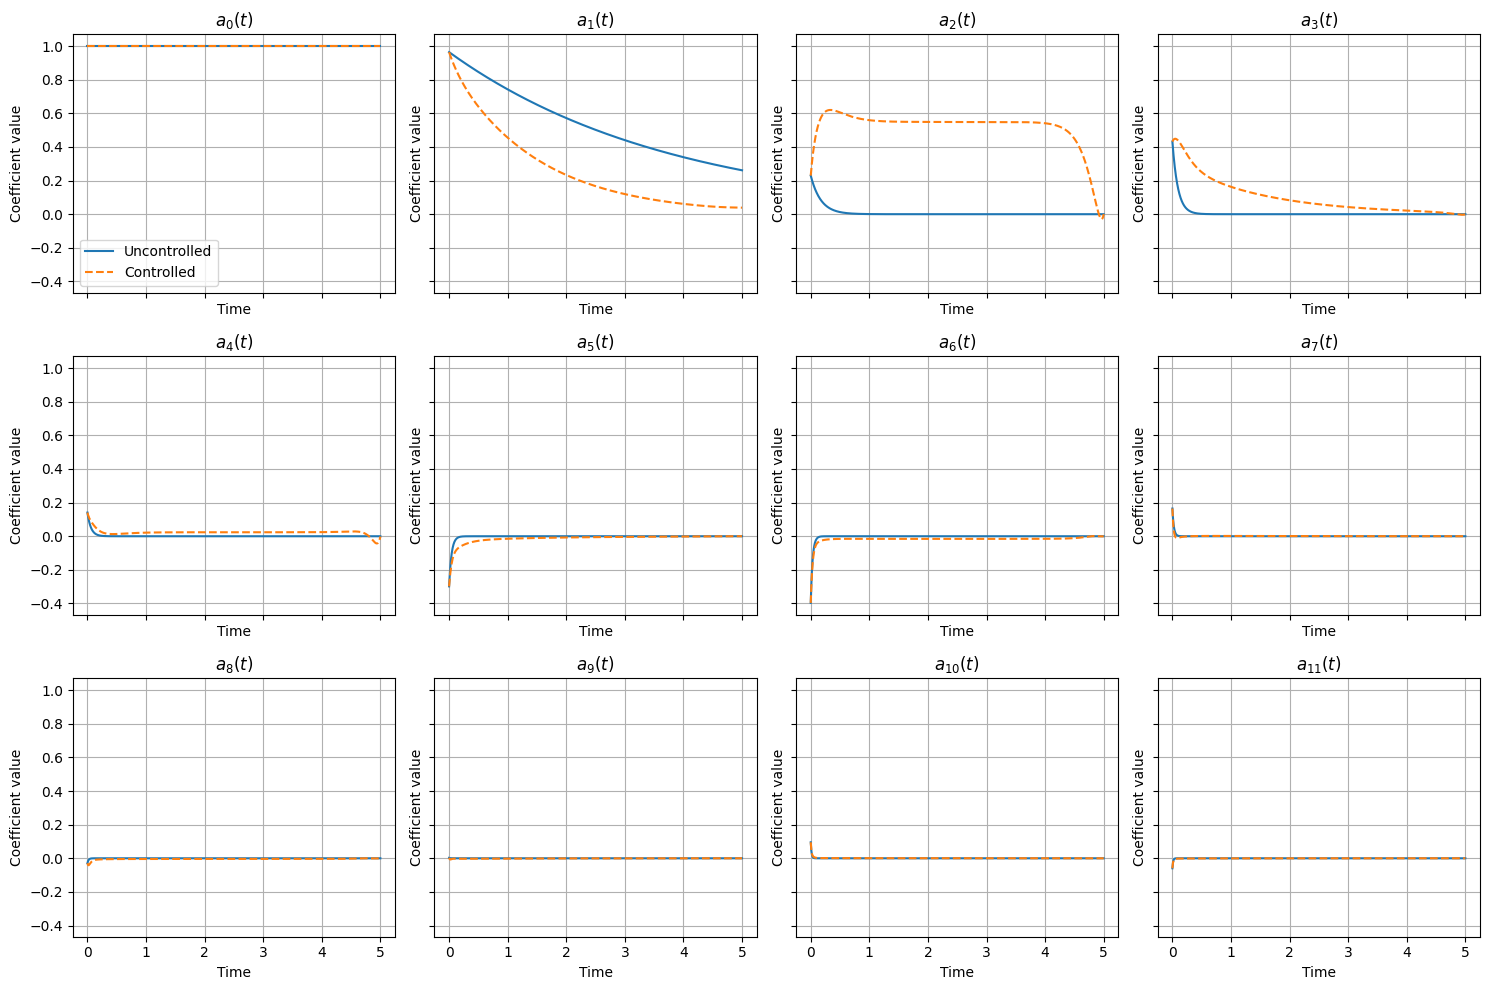

In [16]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

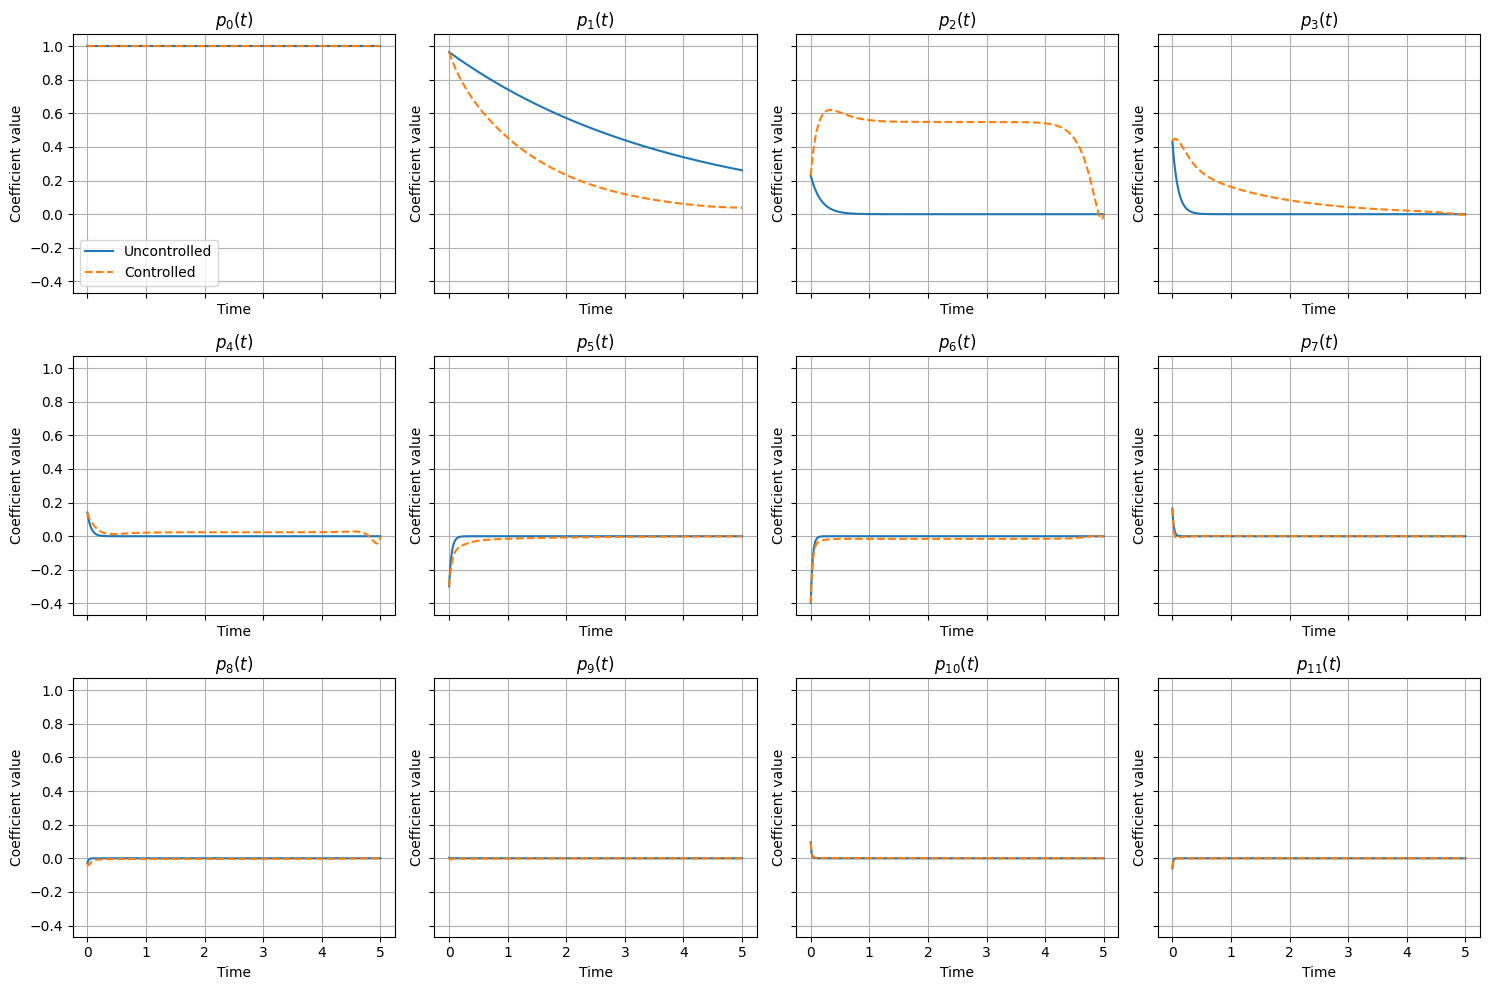

In [17]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$p_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### Checking what could be going wrong

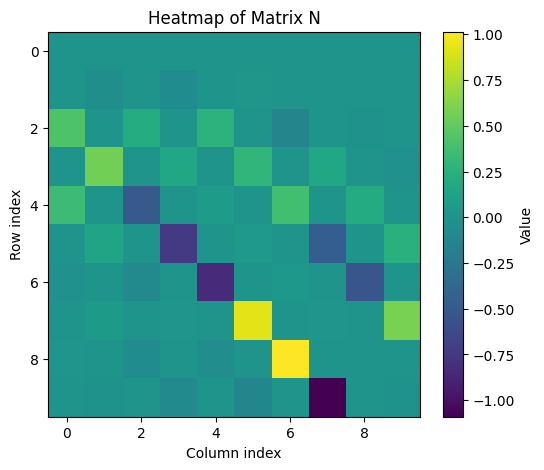

In [18]:
plt.figure(figsize=(6, 5))
plt.imshow(solver.Delta[0][:10,:10], cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Heatmap of Matrix N')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.show()

## Example 3: $V(x) = (x^2 - 1.5)^2$

Let's choose $\alpha$ in a trivial way, uniform.

In [21]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, max_iter=200, tol=1e-8, time_eval=np.linspace(0, T, 1001), verbose=True,
                              #learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.8, 'beta': 0.9},
                              learning_rate_kwargs={'gamma': 1}
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

Iteration 1: ||grad|| = 1.329e+00, gamma = 1
Iteration 2: ||grad|| = 1.104e+00, gamma = 1
Iteration 3: ||grad|| = 9.335e-01, gamma = 1
Iteration 4: ||grad|| = 7.960e-01, gamma = 1
Iteration 5: ||grad|| = 6.813e-01, gamma = 1
Iteration 6: ||grad|| = 5.840e-01, gamma = 1
Iteration 7: ||grad|| = 5.009e-01, gamma = 1
Iteration 8: ||grad|| = 4.295e-01, gamma = 1
Iteration 9: ||grad|| = 3.682e-01, gamma = 1
Iteration 10: ||grad|| = 3.156e-01, gamma = 1
Iteration 11: ||grad|| = 2.704e-01, gamma = 1
Iteration 12: ||grad|| = 2.317e-01, gamma = 1
Iteration 13: ||grad|| = 1.985e-01, gamma = 1
Iteration 14: ||grad|| = 1.701e-01, gamma = 1
Iteration 15: ||grad|| = 1.457e-01, gamma = 1
Iteration 16: ||grad|| = 1.250e-01, gamma = 1
Iteration 17: ||grad|| = 1.072e-01, gamma = 1
Iteration 18: ||grad|| = 9.209e-02, gamma = 1
Iteration 19: ||grad|| = 7.923e-02, gamma = 1
Iteration 20: ||grad|| = 6.830e-02, gamma = 1
Iteration 21: ||grad|| = 5.905e-02, gamma = 1
Iteration 22: ||grad|| = 5.123e-02, gamma =

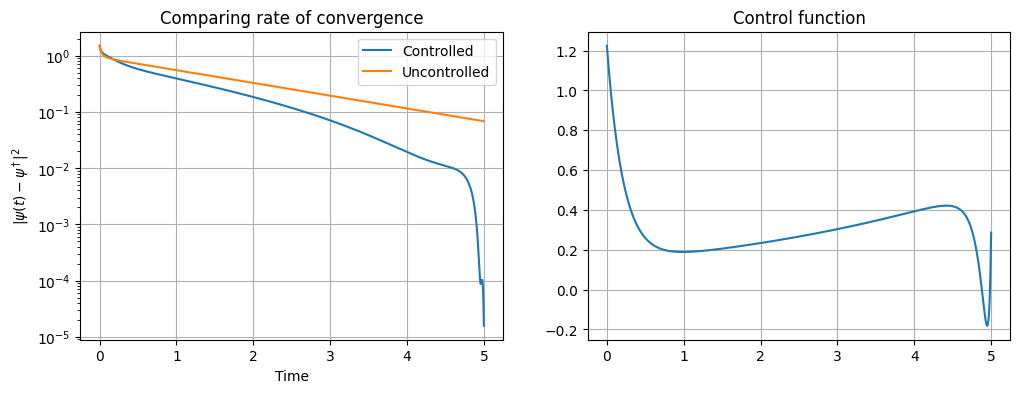

In [22]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

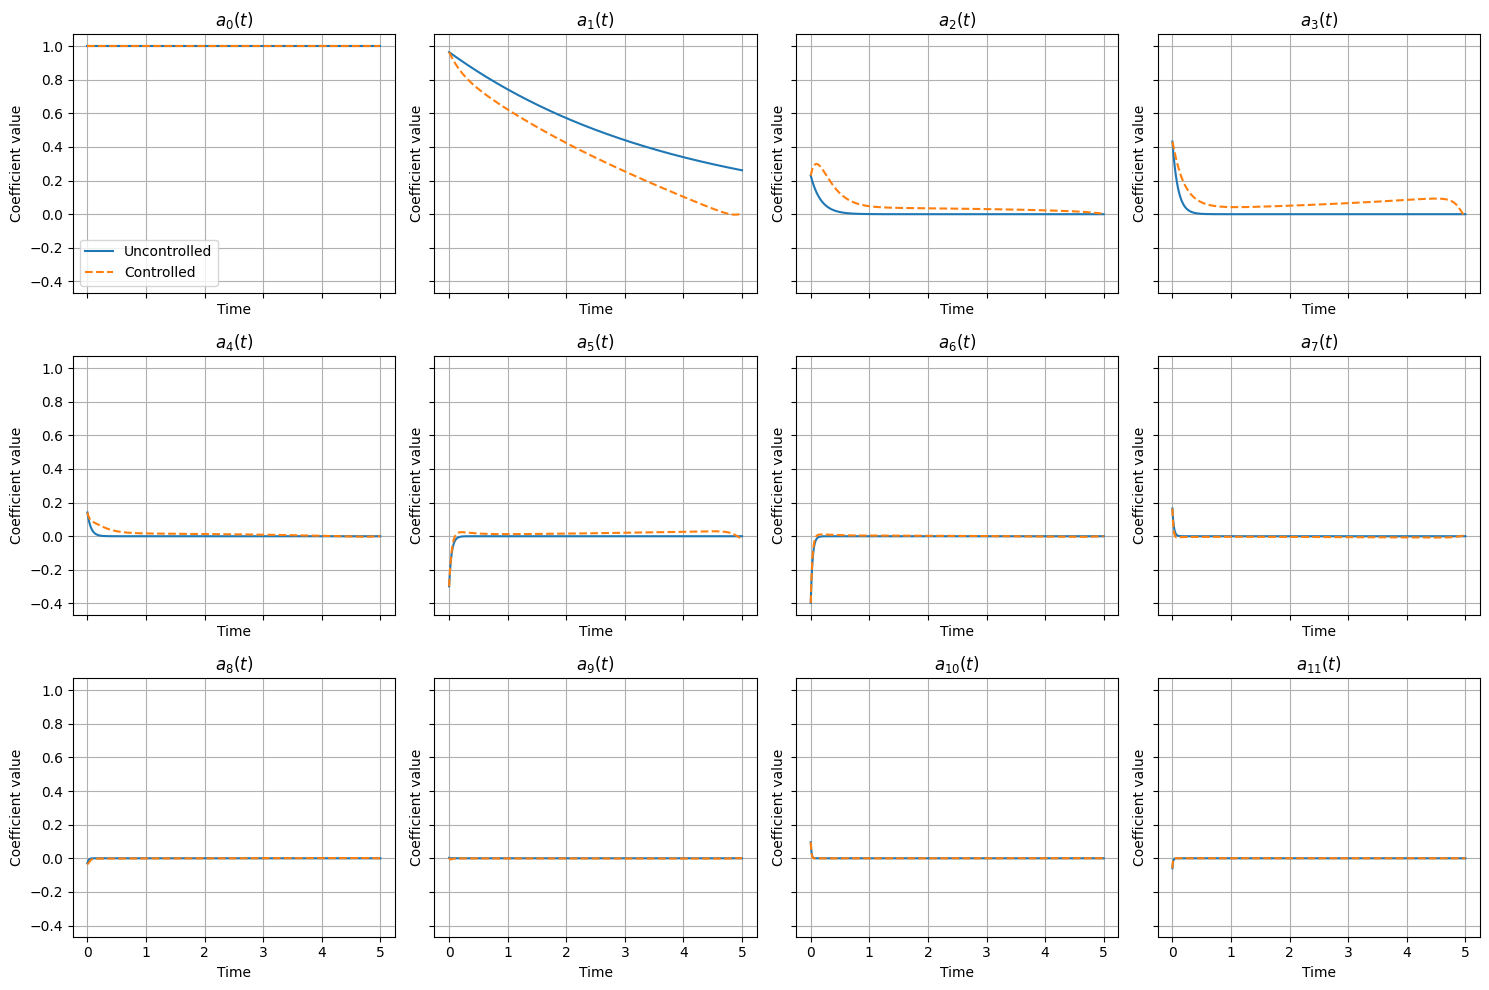

In [23]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 4: $V(x) = (x^2 - 1.5)^2$

Let's include a penalisation $\kappa / 2 ||\psi(\cdot, t) - \psi^\dagger||^2$ in the objective.

In [38]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-6,
    kappa=0.1,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, max_iter=200, tol=1e-8, time_eval=np.linspace(0, T, 1001), verbose=True,
                              learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 100, 'alpha': 0.9, 'beta': 0.9},
                              #learning_rate_kwargs={'gamma': 6},
                             )

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

Iteration 1: ||grad|| = 1.880e-01, gamma = 100
Iteration 2: ||grad|| = 1.551e-01, gamma = 100
Iteration 3: ||grad|| = 1.273e-01, gamma = 100
Iteration 4: ||grad|| = 1.045e-01, gamma = 100
Iteration 5: ||grad|| = 8.588e-02, gamma = 100
Iteration 6: ||grad|| = 7.092e-02, gamma = 100
Iteration 7: ||grad|| = 5.907e-02, gamma = 100
Iteration 8: ||grad|| = 4.968e-02, gamma = 100
Iteration 9: ||grad|| = 4.251e-02, gamma = 100
Iteration 10: ||grad|| = 3.678e-02, gamma = 100
Iteration 11: ||grad|| = 3.258e-02, gamma = 100
Iteration 12: ||grad|| = 2.906e-02, gamma = 100
Iteration 13: ||grad|| = 2.656e-02, gamma = 100
Iteration 14: ||grad|| = 2.427e-02, gamma = 100
Iteration 15: ||grad|| = 2.267e-02, gamma = 100
Iteration 16: ||grad|| = 2.102e-02, gamma = 100
Iteration 17: ||grad|| = 1.988e-02, gamma = 100
Iteration 18: ||grad|| = 1.858e-02, gamma = 100
Iteration 19: ||grad|| = 1.769e-02, gamma = 100
Iteration 20: ||grad|| = 1.661e-02, gamma = 100
Iteration 21: ||grad|| = 1.587e-02, gamma = 100
I

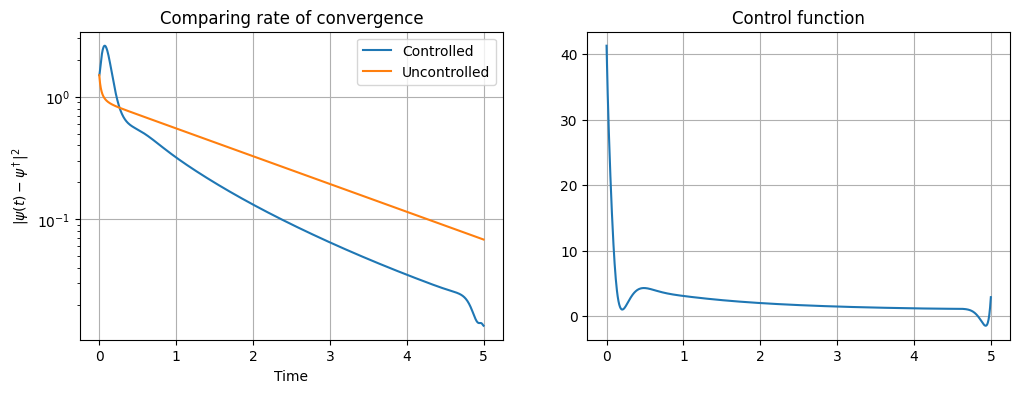

In [39]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

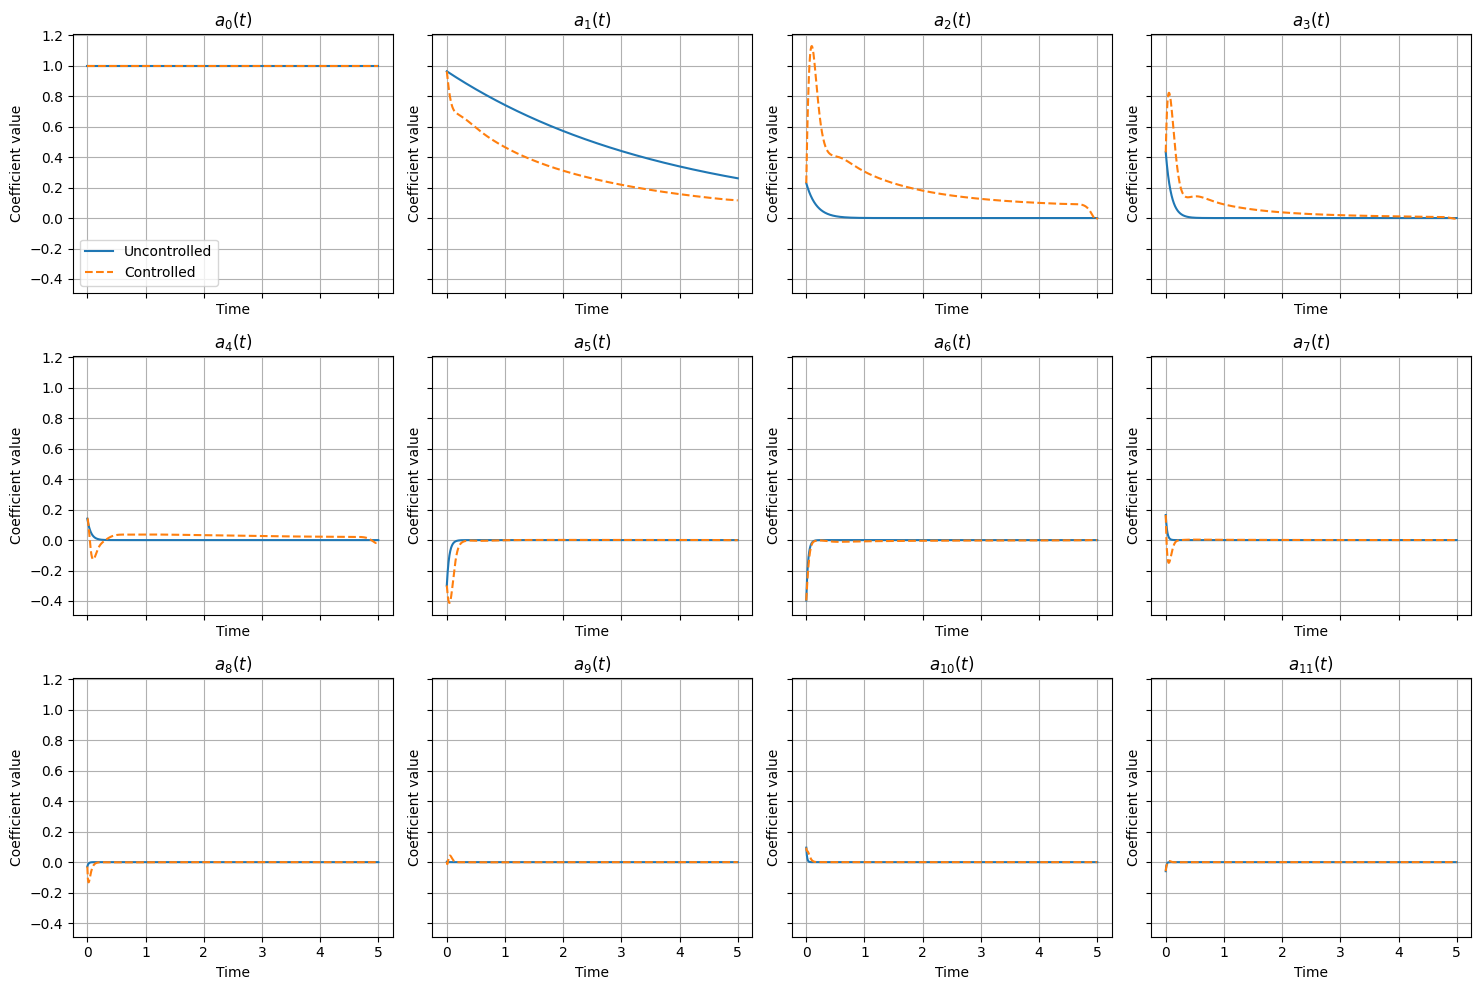

In [40]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 5

Same thing as before...

In [78]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=5000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2
time_eval = np.arange(0, 11, 0.02)

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    nu=1e-4,
    kappa=0.5,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control = solver.solve(T=T, t_free=10.0, max_iter=1000, tol=1e-8, time_eval=time_eval, verbose=True,
                              #learning_rate_kwargs={'method': 'backtracking', 'gamma_init': 1000, 'alpha': 0.99, 'beta': 0.9},
                              learning_rate_kwargs={'gamma': 0.6}, inicialization=True
                             )

result = solver.solve(T=T, t_free=10.0, max_iter=200, tol=1e-10, time_eval=time_eval, verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 3.127e-01, gamma = 0.6
Iteration 2: ||grad|| = 3.117e-01, gamma = 0.6
Iteration 3: ||grad|| = 3.108e-01, gamma = 0.6
Iteration 4: ||grad|| = 3.099e-01, gamma = 0.6
Iteration 5: ||grad|| = 3.090e-01, gamma = 0.6
Iteration 6: ||grad|| = 3.081e-01, gamma = 0.6
Iteration 7: ||grad|| = 3.071e-01, gamma = 0.6
Iteration 8: ||grad|| = 3.062e-01, gamma = 0.6
Iteration 9: ||grad|| = 3.053e-01, gamma = 0.6
Iteration 10: ||grad|| = 3.044e-01, gamma = 0.6
Iteration 11: ||grad|| = 3.035e-01, gamma = 0.6
Iteration 12: ||grad|| = 3.025e-01, gamma = 0.6
Iteration 13: ||grad|| = 3.016e-01, gamma = 0.6
Iteration 14: ||grad|| = 3.007e-01, gamma = 0.6
Iteration 15: ||grad|| = 2.998e-01, gamma = 0.6
Iteration 16: ||grad|| = 2.989e-01, gamma = 0.6
Iteration 17: ||grad|| = 2.980e-01, gamma = 0.6
Iteration 18: ||grad|| = 2.971e-01, gamma = 0.6
Iteration 19: ||grad|| = 2.961e-01, gamma = 0.6
Iteration 20: ||grad|| = 2.952e-01, gamma = 0.6
Iteration 21: 

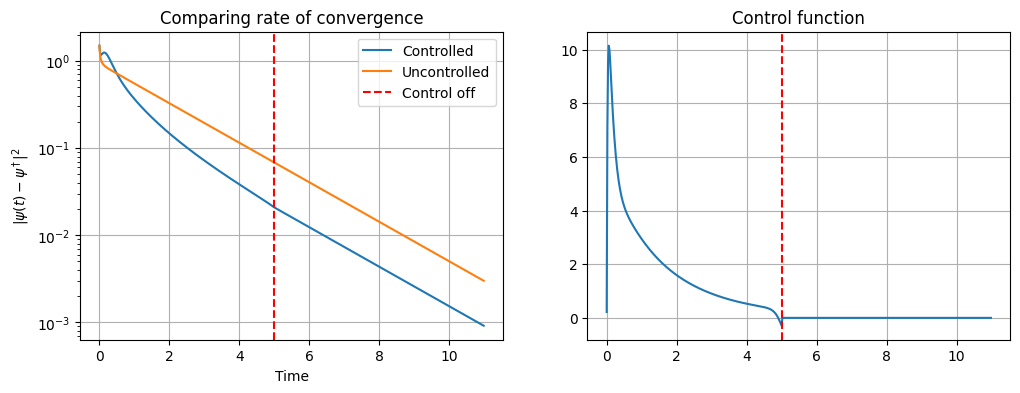

In [81]:
diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_anothercontrol = np.trapezoid((result2['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].axvline(T, c='red', ls='--', label='Control off')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
#ax[1].plot(result_control['time'][result_control['time'] <= T], solver.u_initial)
ax[1].axvline(T, c='red', ls='--')
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

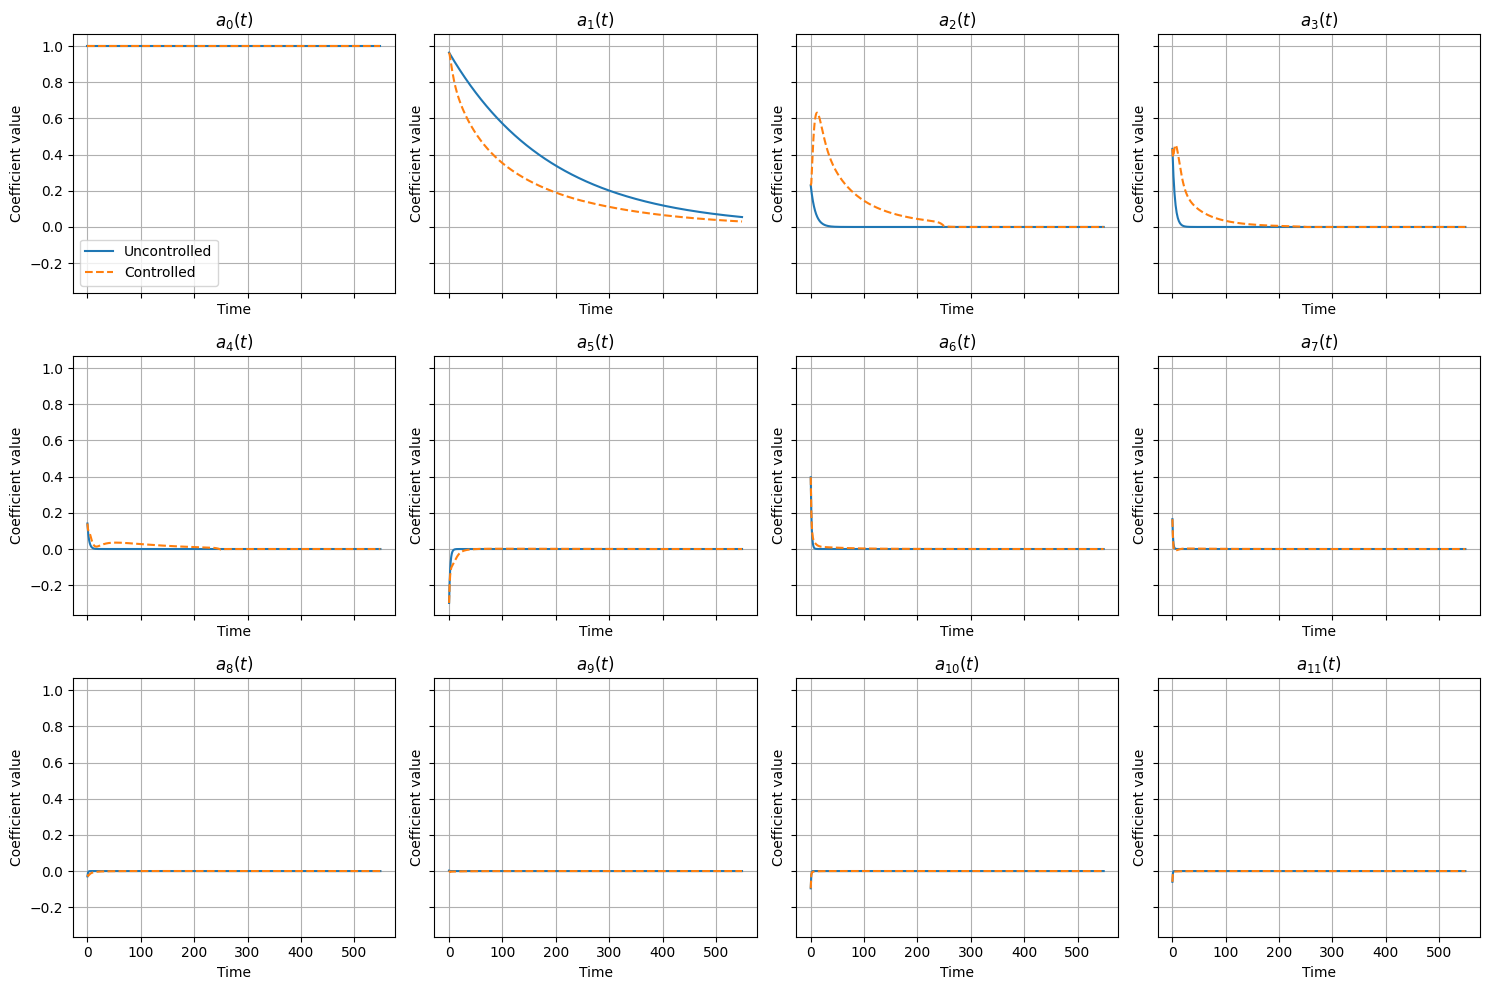

In [82]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Understanding the space we are trying to work with 

Here I will understand $u(t) = A e^{-\lambda t}$ with parameters $A$ and $\lambda$. The idea is to plot the cost functional on $A$ and $\lambda$. 

In [242]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0,
    nu=1e-3,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

In [232]:
T = 5.0
time_eval = np.linspace(0, T, 1000)

A_values = np.linspace(-100, 100, 31)
lambda_values = np.linspace(0.5, 10, 31)

cost_matrix = np.zeros((len(A_values), len(lambda_values)))

for i, A in enumerate(A_values):
    for j, lam in enumerate(lambda_values):
        u_func = lambda t, A=A, lam=lam: A * np.exp(-lam * t)
        cost = solver.compute_cost_functional([u_func], T, time_eval)
        cost_matrix[i, j] = cost

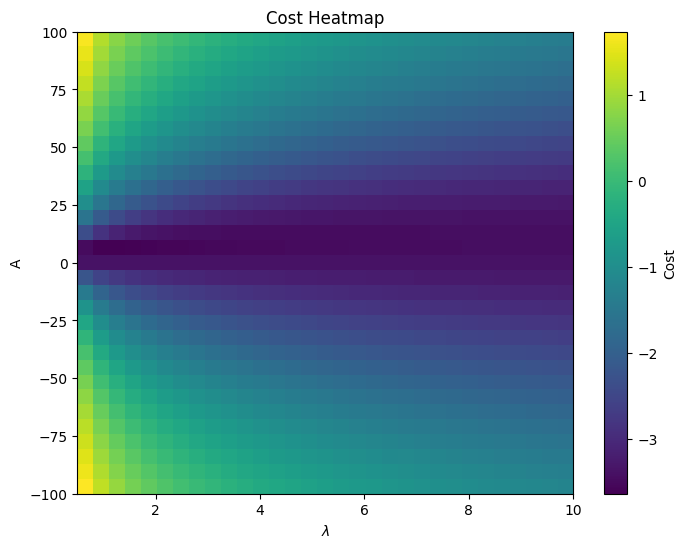

In [233]:
plt.figure(figsize=(8, 6))
plt.imshow(np.log(cost_matrix), origin='lower', extent=[lambda_values[0], lambda_values[-1], A_values[0], A_values[-1]],
           aspect='auto', cmap='viridis')
plt.xlabel(r'$\lambda$')
plt.ylabel('A')
plt.title('Cost Heatmap')
cbar = plt.colorbar()
cbar.set_label('Cost')
plt.show()

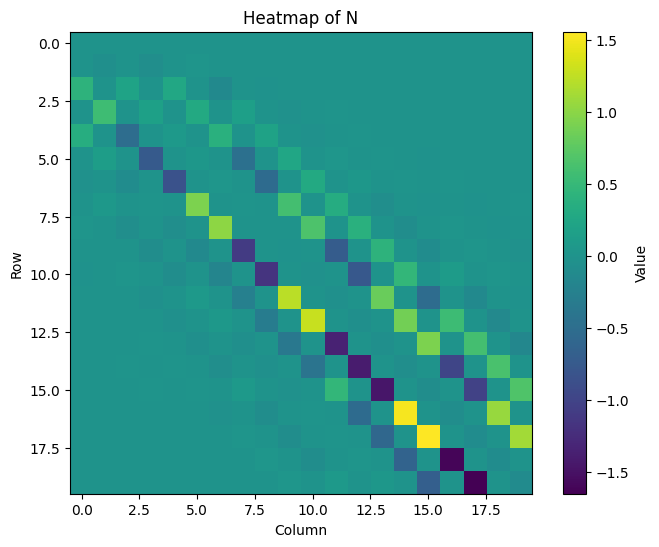

In [238]:
plt.figure(figsize=(8, 6))
plt.imshow(solver.Delta[0], cmap='viridis', interpolation='nearest')
plt.colorbar(label='Value')
plt.title("Heatmap of N")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [323]:
A = np.eye(5)
A[0,0] = 2.0
A[::-1]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [2., 0., 0., 0., 0.]])